# Assignment 5

- bias-variance trade-off

- decision tree regression

- XGBoost

- k-fold cross validation

In [37]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold

# Decision tree regression and bias-variance trade-off

create a bias/variance plot for estimating the following data using a decision tree. 

The model complexity measure is "tree depth"

we train the decision trees at different depths and then plot the error on a training set and a test set

We see that the training error and testing error diverge at some point. 

We want to investigate the difference between bias and variance.

denote $f^*(x)$ to be the true function. 

$$f^*(x) = 2 x^2 - x$$

observations are, where $w_i$ is noise. 

$$y_i = f^*(x_i) + w_i$$ 

Let the training data be $X \in \mathbb{R}^{n \times 1}$ and $y \in \mathbb{R}^{n}$.

Our estimate at a given depth $d$ is $\widehat{f}_d(x)$. Note that our estimate is dependent on the training data $X$ and $y$.

Let $\xi$ be a sample point. 

bias of the estimator at point $\xi$ to be, expected value is taken with respect to $X$ and $y$.
$$
\text{bias}_d(\xi) = \mathbb{E}[\widehat{f}_d(\xi)] - f^*(\xi)
$$


The variance is simply
$$
\text{variance}_d(\xi) = \textrm{Var}(\widehat{f}_d)
$$

We would like to estimate these values. 

we generate $M$ random instances of training set, for each $m \in [M]$, we have a function estimate $\widehat{f}_d^m(\xi)$. 

With that we can approximate
$$
(\text{bias}_d(\xi))^2 \approx \left (\frac{1}{M} \sum_{m=1}^M \widehat{f}_d(\xi) - f^*(\xi) \right )^2
$$

and

$$
\text{variance}_d(\xi) = \text{empirical variance} \left [ \widehat{f}^m_d(\xi) \right ]
$$

Text(0.5, 0.98, 'Decision Tree Regression')

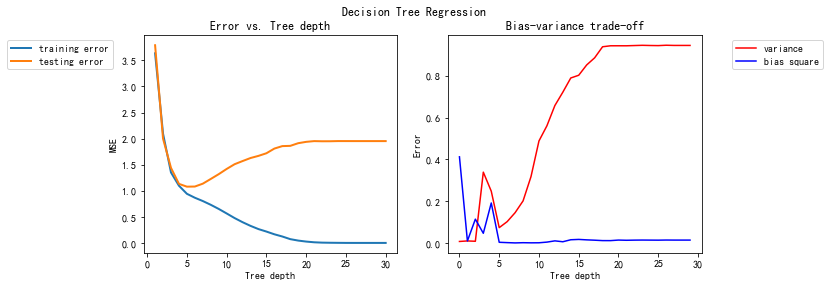

In [32]:
def f(X):
  """True function"""
  return 2*X**2-X


def biasvsvariancetree(sample_point: np.ndarray, numtrials : int=100, maxdepth: int=30):
    """ 
    @params
    sample_point: a sample point to give estimate of y
    numtrials: M, number of trials to estimate y
    maxdepth: max tree depth
    """
    fhat = np.zeros((numtrials,maxdepth))
    n=1000
    p=1
    for t in range(numtrials):
        X = np.random.rand(n, p)*4-2
        y = f(X[:, 0]) + np.random.randn(n)
        for k in range(1,maxdepth+1):
            reg = DecisionTreeRegressor(max_depth=k).fit(X, y)
            fhat[t, k-1] = reg.predict(sample_point[:,None])
    return fhat



# data
n=2000  # sample size
p=1     # feature size
X = np.random.rand(n, p)*4-2
y = f(X[:, 0]) + np.random.randn(n)
# split dataset into training set and testing set
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2)

train_error = np.zeros((30))
test_error = np.zeros((30))
# for tree depth [1, 30]
for j in range(1, 31):
    model = DecisionTreeRegressor(max_depth=j).fit(Xtrain,ytrain)
    train_error[j-1] = np.mean((ytrain - model.predict(Xtrain)) ** 2)
    test_error[j-1] = np.mean((ytest - model.predict(Xtest)) ** 2)


samplepoint = np.array([1])    #Pick a sample point
fhat = biasvsvariancetree(samplepoint, maxdepth=30)
fhatmean = np.mean(fhat,axis=0)
fhatvar  = np.var(fhat,axis=0)
fhatbias = (f(samplepoint) - fhatmean)**2


fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(np.arange(1,31),train_error,linewidth=2,label='training error')
axs[0].plot(np.arange(1,31),test_error,linewidth=2,label='testing error')
axs[0].legend(bbox_to_anchor=(-0.1, 1))
axs[0].set_xlabel("Tree depth")
axs[0].set_ylabel("MSE")
axs[0].set_title("Error vs. Tree depth")

axs[1].plot(fhatvar,color='red',label='variance')
axs[1].plot(fhatbias,color='blue',label='bias square')
axs[1].legend(bbox_to_anchor=(1.1, 1))
axs[1].set_xlabel("Tree depth")
axs[1].set_ylabel("Error")
axs[1].set_title("Bias-variance trade-off")

fig.suptitle("Decision Tree Regression")

# XGBoost

When training a XGBoost (boosted decision tree) there are a number of parameters that one must consider.

Use cross validation to pick these parameters.

- tree depth `'max_depth'`

- learning rate `'eta'`

- total number of added trees `num_boost_round`

Before training, you can decided to do imputation and feature standardization or not.

## Simulated data

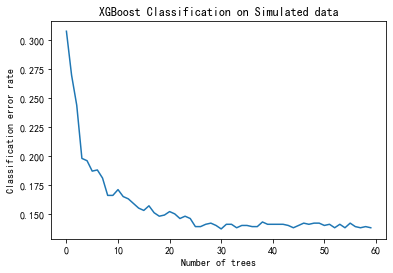

In [54]:
n=1000
p=10

# training set
xtrain = pd.DataFrame(np.random.randn(n,p))          # features: convert numpy array into pandas dataframe for making XGBoost datamatrix
ytrain = (xtrain @ np.ones(p) + .5*np.random.randn(n)) > 0 # binary labels
data_train = xgb.DMatrix(xtrain, label = ytrain)               # combine features and labels into XGBoost datamatrix

# testing set
xtest = pd.DataFrame(np.random.randn(n,p))
ytest = (xtest @ np.ones(p) + .5*np.random.randn(n)) > 0
data_test = xgb.DMatrix(xtest, label=ytest)         # combine features and labels into XGBoost datamatrix

# training
params = {'max_depth': 7, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric': 'logloss'} # specify parameters in a dict

max_trees = 60
bst = xgb.train(params, data_train, num_boost_round=max_trees)   # num_boost_round = Number of boosting iterations = number of added trees

# prediction
errors_vs_numtrees = np.array([np.mean(np.logical_xor(bst.predict(data_test, iteration_range=(0, j)) > 0.5, ytest)) for j in range(1,max_trees+1)])
plt.plot(errors_vs_numtrees)
plt.xlabel("Number of trees")
plt.ylabel("Classification error rate")
plt.title("XGBoost Classification on Simulated data")
plt.show()


Without retraining the model above. What is the prediction on test data using only 57 trees?

In [55]:
j = 57
yhat_57trees = bst.predict(data_test, iteration_range=(0, j))
yhat_57trees.shape

(1000,)

## Spam dataset

Complete the function below called `cvfunc` that will do five fold cross-validation. 

The function will train on the training fold and compute the mis-classification error for each possible number of trees on validation fold

In [78]:
def cvfunc(x: np.ndarray, y: np.ndarray, params: dict, max_trees: int=1000, folds : int=5) -> np.ndarray:
  """
  k-fold cross validation

  x: input. shape (n, p)
  y: output shape=(n,)
  params: a dictionary of the parameters
  max_trees: max number of trees in the boosting method
  folds: number of folds in cross validation

  return: mis-classification error rate, shape: (max_trees,)
  """
  kf = KFold(n_splits=folds, shuffle=True) 
  cv_error = np.zeros((folds, max_trees))

  for i, (train_index, test_index) in enumerate(kf.split(x)):
    dtrain = xgb.DMatrix(x[train_index,:], label = y[train_index])
    dtest = xgb.DMatrix(x[test_index,:],label = y[test_index])
    ytest = y[test_index]

    # training on train-fold
    bst = xgb.train(params, dtrain, num_boost_round=max_trees)
    # compute mis-classification error rate on validation-fold
    cv_error[i] = np.array([np.mean(np.logical_xor(bst.predict(dtest, iteration_range=(0, j))>0.5,ytest)) for j in range(1, max_trees+1)])

  return np.mean(cv_error, axis=0)

### Part c)

We will now perform cross validation across all combinations below.

- tree_depth_choices: $1 \sim 8$

- learning_rate_choices: $0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1$

- possible_trees: $1 \sim 1000$

Note that you do **not** need to retrain the model for each possible tree size. 

Instead you can just train for the maximum number of trees and then use `bst.predict(dtest, iteration_range=(0, j)` to extract tree at number

In [60]:
leadstring = '/Users/wenxinxu/Desktop/SDS565/data/spam/'
dftrain = pd.read_csv(leadstring+'spam_train_withlabels.csv')
dftest = pd.read_csv(leadstring+'spam_test_nolabels.csv')

ytrain = dftrain['spam']
dftrain = dftrain.drop(['spam', 'capital_run_length_average'],axis=1) # drop label column and feature column with missing data

In [85]:
folds = 5
tree_depth_choices = np.arange(1, 9)
learning_rate_choices = [0.005,0.01,0.05,0.1,0.3,0.5,1]
possible_trees = range(1,1000)

errors = np.zeros((len(tree_depth_choices),len(learning_rate_choices), len(possible_trees)))
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss'}

for i, depth in enumerate(tree_depth_choices):
  params['max_depth'] = depth
  for j, lr in enumerate(learning_rate_choices):
    params['eta'] = lr
    errors[i, j] = cvfunc(dftrain.values, ytrain.values, params, max_trees=max(possible_trees), folds=folds)


idx = np.unravel_index(np.argmin(errors), errors.shape)
params['max_depth'] = tree_depth_choices[idx[0]]
params['eta'] = learning_rate_choices[idx[1]]
max_trees = possible_trees[idx[2]]

print(f"""5-fold CV: Optimal combination of hyperparameters: max_depth: {params['max_depth']}, eta: {params['eta']}, max_trees: {max_trees}
Mis-classification error rate {np.round(np.min(errors), 5)}""")


dtrain = xgb.DMatrix(dftrain.values,label=ytrain.values)
dtest = xgb.DMatrix(dftest.drop(['capital_run_length_average'],axis=1).values)

# training using tuned hyperparameters
bst = xgb.train(params, dtrain, num_boost_round=max_trees)

# prediction 
test_pred = pd.DataFrame(bst.predict(dtest, iteration_range=(0, max_trees)) > 0.5, columns=['xgboost prediction'])

5-fold CV: Optimal combination of hyperparameters: max_depth: 3, eta: 0.3, max_trees: 166
Mis-classification error rate 0.03977


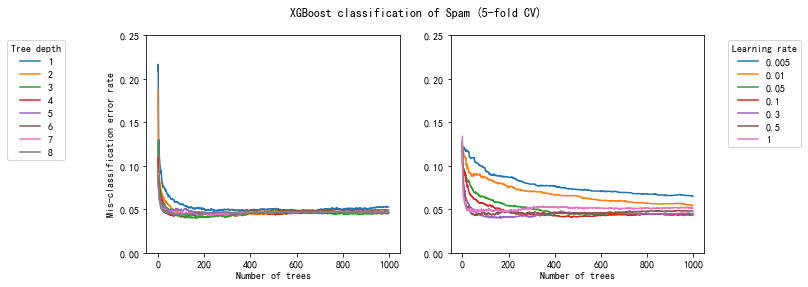

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i in range(errors.shape[0]):
  axs[0].plot(errors[i, idx[1], :], label=tree_depth_choices[i])

for j in range(errors.shape[1]):
  axs[1].plot(errors[idx[0], j, :], label=learning_rate_choices[j])

axs[0].legend(title="Tree depth", bbox_to_anchor=(-0.3, 1))
axs[0].set_xlabel("Number of trees")
axs[0].set_ylabel("Mis-classification error rate")
axs[0].set_ylim(0, 0.25)

axs[1].legend(title="Learning rate", bbox_to_anchor=(1.4, 1))
axs[1].set_xlabel("Number of trees")
axs[1].set_ylim(0, 0.25)

fig.suptitle(f"XGBoost classification of Spam ({folds}-fold CV)")
plt.show()
